In [1]:
!pip install -q gdown

file_id = '1LgjPFk7tgCRhJVfL8SCKX9Z1N2wK4_6_'
output = 'dataset.zip'
!gdown --id $file_id --output $output
!unzip -q $output

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1LgjPFk7tgCRhJVfL8SCKX9Z1N2wK4_6_
From (redirected): https://drive.google.com/uc?id=1LgjPFk7tgCRhJVfL8SCKX9Z1N2wK4_6_&confirm=t&uuid=12e9446c-a5cb-47e7-a2b9-d805ebc53f3e
To: /content/dataset.zip
100% 2.38G/2.38G [00:41<00:00, 57.5MB/s]


In [2]:
!ls

dataset  dataset.zip  sample_data


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness


In [4]:
train_ds= keras.utils.image_dataset_from_directory(
    directory="dataset/Task_A/train",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(160, 160), #change
    shuffle=True
)
val_ds= keras.utils.image_dataset_from_directory(
    directory="dataset/Task_A/val",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(160, 160) #change
)


Found 1926 files belonging to 2 classes.
Found 422 files belonging to 2 classes.


In [5]:
#normalise
def process(image, label):
    image = tf.cast(image/255, tf.float32)
    return image, label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)
#so all pixel values are between 0 and 1


In [6]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
   #RandomRotation(0.1),
    RandomZoom(0.1),
    #tf.keras.layers.Rescaling(1./255)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [7]:
total_female = 303 + 79
total_male = 1623 + 343

weight_for_female = (total_female + total_male) / (2 * total_female)
weight_for_male = (total_female + total_male) / (2 * total_male)

class_weights = {0: weight_for_female, 1: weight_for_male}


In [8]:
from keras.regularizers import l2
model = Sequential([
    Input(shape=(160, 160, 3)), #change

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)), #change
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)), #change
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)), #change
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)), #change
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)), #change
    Dropout(0.1), #change

    Dense(1, activation='sigmoid')
])


In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 158, 158, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 77, 77, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 36, 36, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,411,009 (20.64 MB)

 Trainable params: 5,410,561 (20.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # change
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step - accuracy: 0.6587 - loss: 2.3832 - val_accuracy: 0.6825 - val_loss: 1.3965 - learning_rate: 0.0010
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.7321 - loss: 1.7472 - val_accuracy: 0.1872 - val_loss: 8.2512 - learning_rate: 0.0010
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.7260 - loss: 1.5718 - val_accuracy: 0.4668 - val_loss: 2.2078 - learning_rate: 0.0010
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.7828 - loss: 1.2836 - val_accuracy: 0.6469 - val_loss: 1.6952 - learning_rate: 3.0000e-04
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.8387 - loss: 1.1538 - val_accuracy: 0.8057 - val_loss: 1.2499 - learning_rate: 3.0000e-04
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.8656 - loss: 1.0282 - val_accuracy: 0.7773 - val_loss: 1.2506 - learning_rate: 3.0000e-04
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.859

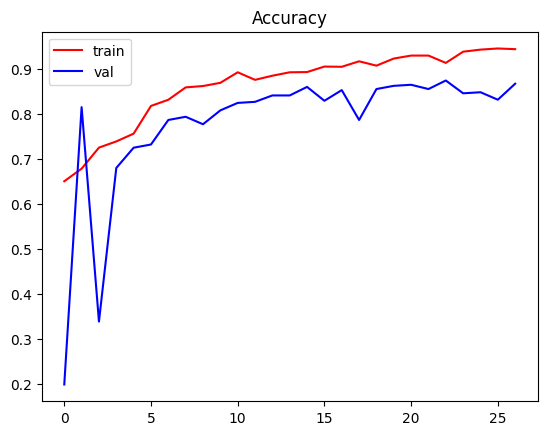

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='val')
plt.title('Accuracy')
plt.legend()
plt.show()

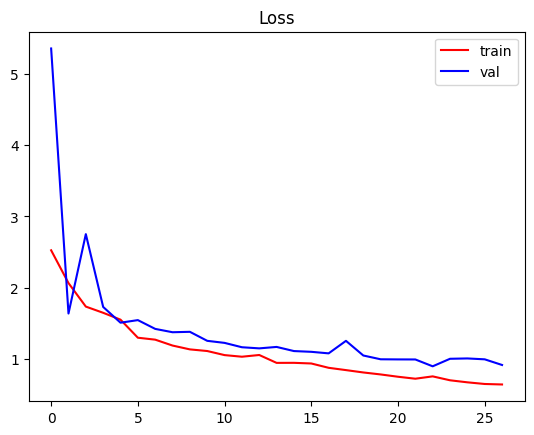

In [ ]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='val')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")

Final Training Accuracy: 94.40%
Final Validation Accuracy: 86.73%
